# Import libraries

In [26]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, SimpleRNN, LSTM
from keras.datasets import imdb
from keras.utils.data_utils import pad_sequences
from keras.preprocessing.text import Tokenizer

import numpy as np

import matplotlib.pyplot as plt

import os

# Import data

In [27]:
max_features = 10000
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = pad_sequences(x_train, maxlen=maxlen)

x_test = pad_sequences(x_test, maxlen=maxlen)

print(x_train.shape)


(25000, 20)


# First model: Simple classifier

In [28]:
model = Sequential()

model.add(Embedding(max_features, 8, input_length=maxlen))

model.add(Flatten())

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

model.summary()

history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 20, 8)             80000     
                                                                 
 flatten_4 (Flatten)         (None, 160)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 2s 2ms/step - loss: 0.6743 - acc: 0.6134 - val_loss: 0.6301 - val_acc: 0.6956
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5550 - acc: 0.7483 - val_loss: 0.5333 - val_acc: 0.7280
Epoch 3/10
625/625 [==============================

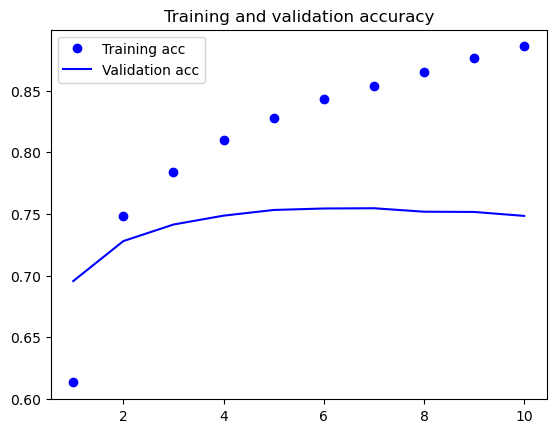

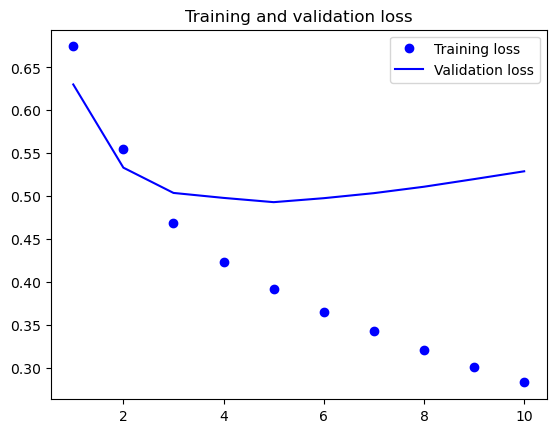

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We are getting a validation accuracy of 0.75 which is not bad for a first try. Next we'll try to use a pretrained word embedding called GloVe.

# Using a pretrained word embedding

Instead of using the pretokenized IMDB data packaged in Keras, we will start from scratch and tokenize the raw text ourselves. We will then train a simple model using an Embedding layer and evaluate it on the test set.

In [4]:
imdb_dir = './aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)

    for fname in os.listdir(dir_name):

        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
        if label_type == 'neg':
            labels.append(0)
        else:
            labels.append(1)


In [5]:
print(texts[0])
print(labels[0])

the only thing great about the movie is its title. In this case, "Snake On a Plane" is example of not judging the book by its cover, the title says nothing about the movie. When I went to the theater, I wasn't expecting Citizen Kane, I was expecting Independence Day, a movie that's pure popcorn fun, but instead, I got that horrible Roy Liotta movie called " Turbulence" Yes, this is how bad SOAP is. The only thing make SOAP better is its title. And it's not even the apporiate title for the movie, the wasn't even a glimpse of "snake" or "plane" 40 minutes into the movie! What a false advertising! If it wasn't for its title, SOAP would be just another unforgettable cheap B-grade summer movie. And the R rating? It has to be the most undeserved R rated movie of all time! The makers of the movie only add a few f word to make this a R, All of the violence are kept pg-13 level. You know what's really R rated? The R rated superstar Edge! See him at Summerslam instead of waste your money on a sn

In [6]:
maxlen = 20
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.array(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 20)
Shape of label tensor: (25000,)


In [7]:
glove_dir = './glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [8]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [9]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 100)           1000000   
                                                                 
 flatten_1 (Flatten)         (None, 2000)              0         
                                                                 
 dense_1 (Dense)             (None, 32)                64032     
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,064,065
Trainable params: 1,064,065
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [11]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 75ms/step - loss: 0.8663 - acc: 0.4400 - val_loss: 0.8697 - val_acc: 0.5041
Epoch 2/10
7/7 [==============================] - 0s 55ms/step - loss: 0.6331 - acc: 0.6850 - val_loss: 0.8245 - val_acc: 0.5090
Epoch 3/10
7/7 [==============================] - 0s 67ms/step - loss: 0.5470 - acc: 0.7450 - val_loss: 0.7270 - val_acc: 0.5207
Epoch 4/10
7/7 [==============================] - 0s 83ms/step - loss: 0.4275 - acc: 0.8600 - val_loss: 0.9364 - val_acc: 0.5077
Epoch 5/10
7/7 [==============================] - 0s 65ms/step - loss: 0.3797 - acc: 0.8750 - val_loss: 0.9461 - val_acc: 0.5031
Epoch 6/10
7/7 [==============================] - 0s 78ms/step - loss: 0.3300 - acc: 0.9250 - val_loss: 0.7781 - val_acc: 0.5308
Epoch 7/10
7/7 [==============================] - 0s 81ms/step - loss: 0.2357 - acc: 0.9950 - val_loss: 0.7658 - val_acc: 0.5434
Epoch 8/10
7/7 [==============================] - 0s 67ms/step - loss: 0.1926 - acc: 0.9900 - val

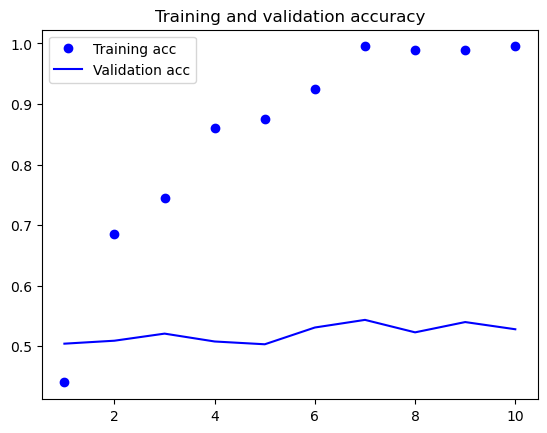

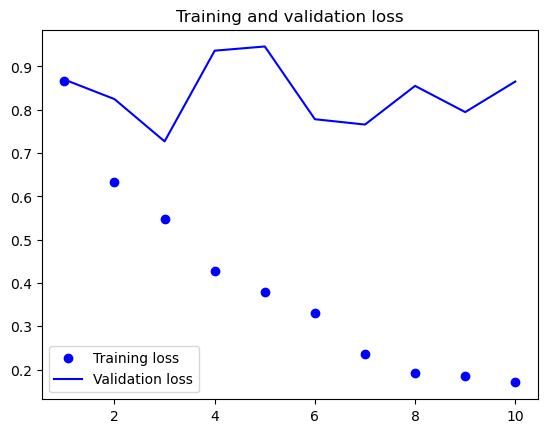

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We are getting a validation score of 0.5 and the model is clearly overfitting. This is because we have a very small training set of 200 samples, and the glove embedding is a generic embedding that is not specific to our training set. Next we'l  not freeze the embedding layer and train it along with the rest of the model, so we can learn a task-specific embedding.

In [32]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_val, y_val))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 20, 100)           1000000   
                                                                 
 flatten_6 (Flatten)         (None, 2000)              0         
                                                                 
 dense_11 (Dense)            (None, 32)                64032     
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,064,065
Trainable params: 1,064,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
782/782 [==============================] - 5s 6ms/step - loss: 0.5442 - acc: 0.7118 - val_loss: 0.8351 - val_acc: 0.5021
Epoch 2/10
782/782 [========================

In [14]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [15]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 2ms/step - loss: 0.8635 - acc: 0.5324


[0.8634992241859436, 0.5324000120162964]

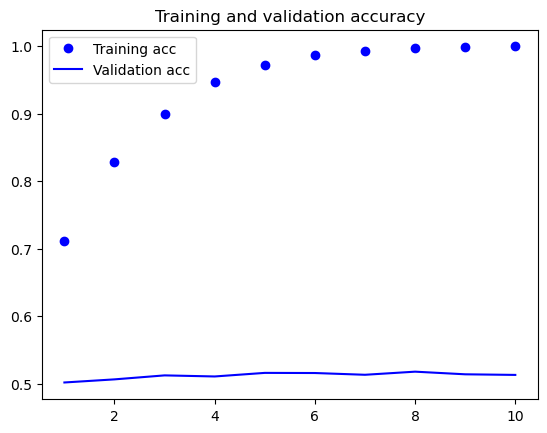

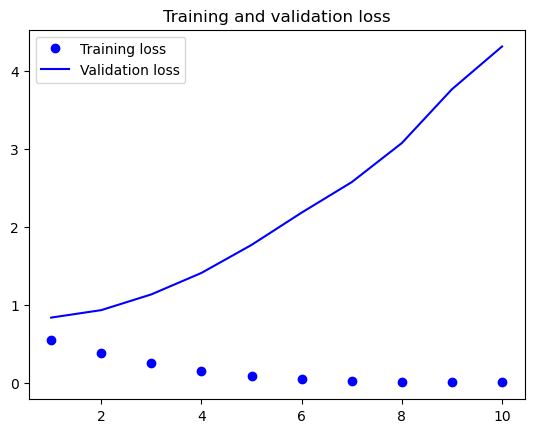

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Still the accuracy stays at 0.5. This is because our training set is too small.

# Reccurent neural networks

## Pseudocode RNN

In [16]:
timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))

state_t = np.zeros((output_features,))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)

    successive_outputs.append(output_t)

    state_t = output_t

final_output_sequence = np.concatenate(successive_outputs, axis=0)

In summary what an RNN does is the following:

- Iterate over the timesteps of a sequence
- At each timestep, consider the current timestep and the information from the previous timesteps
- Update the information at each timestep

This helps the network to build up a sort of memory of the previous timesteps.

In [17]:
model = Sequential()
model.add(Embedding(10000, 32))
# model.add(SimpleRNN(32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 32)          2080      
                                                                 
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [18]:
max_features = 10000
maxlen = 500
batch_size = 32

(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)

print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

input_train = pad_sequences(input_train, maxlen=maxlen)
input_test = pad_sequences(input_test, maxlen=maxlen)



25000 train sequences
25000 test sequences


In [19]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
               metrics=['acc'])

history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 22s 133ms/step - loss: 0.6110 - acc: 0.6535 - val_loss: 0.5559 - val_acc: 0.7142
Epoch 2/10
157/157 [==============================] - 21s 136ms/step - loss: 0.3965 - acc: 0.8321 - val_loss: 0.4113 - val_acc: 0.8236
Epoch 3/10
157/157 [==============================] - 21s 135ms/step - loss: 0.3052 - acc: 0.8767 - val_loss: 0.4123 - val_acc: 0.8166
Epoch 4/10
157/157 [==============================] - 23s 145ms/step - loss: 0.2557 - acc: 0.8999 - val_loss: 0.6476 - val_acc: 0.7672
Epoch 5/10
157/157 [==============================] - 22s 142ms/step - loss: 0.1844 - acc: 0.9315 - val_loss: 0.3854 - val_acc: 0.8488
Epoch 6/10
157/157 [==============================] - 18s 113ms/step - loss: 0.1282 - acc: 0.9559 - val_loss: 0.5667 - val_acc: 0.7762
Epoch 7/10
157/157 [==============================] - 17s 109ms/step - loss: 0.0874 - acc: 0.9707 - val_loss: 0.4982 - val_acc: 0.8140
Epoch 8/10
157/157 [==============================] - 1

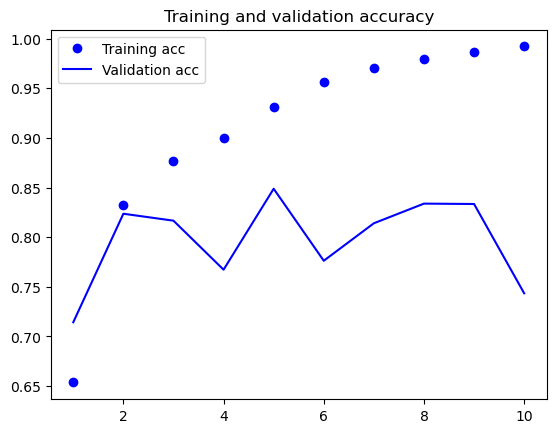

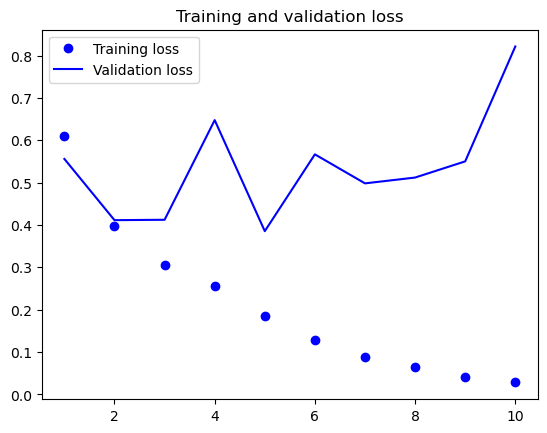

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We get a validation accuracy of 0.86 with RNNS still the model is overfitting. We can't say that the rnn is better in this case, we have a small training set and the rnns will learn specific patterns from the training set, so it will overfit.

# LSTMs

In [23]:
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
            loss='binary_crossentropy',
            metrics=['acc'])

history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)


Epoch 1/10
157/157 [==============================] - 39s 239ms/step - loss: 0.5039 - acc: 0.7598 - val_loss: 0.4176 - val_acc: 0.8304
Epoch 2/10
157/157 [==============================] - 40s 253ms/step - loss: 0.3021 - acc: 0.8826 - val_loss: 0.3640 - val_acc: 0.8600
Epoch 3/10
157/157 [==============================] - 39s 250ms/step - loss: 0.2392 - acc: 0.9107 - val_loss: 0.3216 - val_acc: 0.8752
Epoch 4/10
157/157 [==============================] - 37s 234ms/step - loss: 0.2056 - acc: 0.9238 - val_loss: 0.3460 - val_acc: 0.8578
Epoch 5/10
157/157 [==============================] - 37s 234ms/step - loss: 0.1837 - acc: 0.9340 - val_loss: 0.3305 - val_acc: 0.8704
Epoch 6/10
157/157 [==============================] - 39s 251ms/step - loss: 0.1608 - acc: 0.9423 - val_loss: 0.3006 - val_acc: 0.8886
Epoch 7/10
157/157 [==============================] - 40s 254ms/step - loss: 0.1505 - acc: 0.9464 - val_loss: 0.4481 - val_acc: 0.8636
Epoch 8/10
157/157 [==============================] - 4

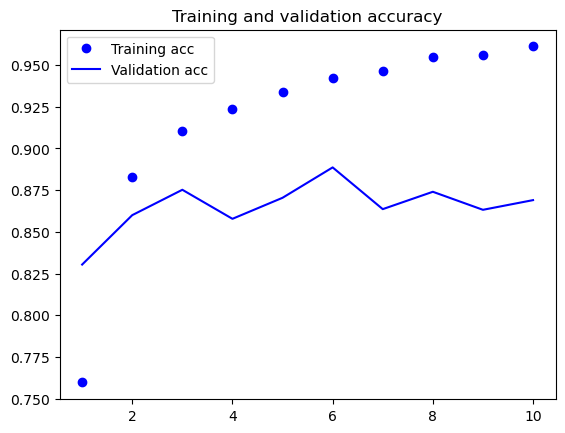

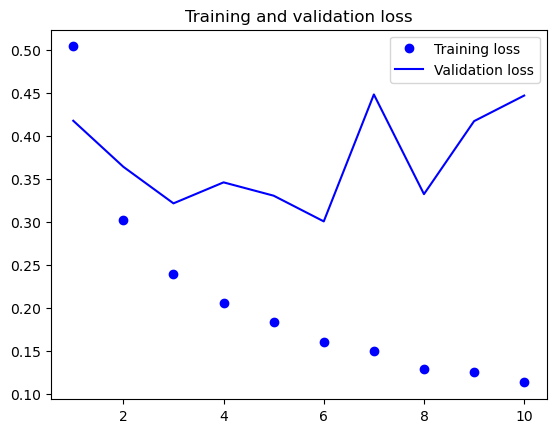

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

With LSTM we get a validation accuracy of 0.876 wich is slightly better than the simple rnn, this is lstms suffer less from the vanishing gradient problem.